# Durée passée dans chaque lieu selon la plage horaire

## I - Base de données

In [ ]:
''' Importation des packages nécessaires '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import scipy.stats
!pip install openpyxl

In [ ]:
emp_df=pd.read_excel("EMP_deplacements.xlsx")
nb_dep_df=emp_df.groupby("IDENT_IND")["num_dep_V"].max().to_frame().rename(columns={"num_dep_V":"nb_dep"})
emp_df=emp_df.set_index("IDENT_IND")
emp_df["nb_dep"]=nb_dep_df["nb_dep"]
emp_df=emp_df.reset_index()
emp_df.head()

### Séparation de la base de données en 4 plages horaires (pour les heures de départ)

In [ ]:
# Matin (départ entre 00h et 11h) :
emp_matin=emp_df[emp_df["HEURE_DEPART"]<=11]
# Midi (départ entre 11h et 14h) :
emp_midi=emp_df[(emp_df["HEURE_DEPART"]>11)&( emp_df["HEURE_DEPART"]<=14)]
# Après-midi (départ entre 14h et 17h) :
emp_am=emp_df[(emp_df["HEURE_DEPART"]>14)&( emp_df["HEURE_DEPART"]<=17)]
# Soir (départ entre 17h et 00h) :
emp_soir=emp_df[(emp_df["HEURE_DEPART"]>17)&( emp_df["HEURE_DEPART"]<=24)]

#### Remarque : Il y a entre 4000 et 7500 déplacements pour chaque plage horaire.

In [ ]:
data=emp_df
data["Durée"]=0 #On crée une colonne "durée"
data.loc[data["nb_dep"]==1,"Durée"]=24-data["HEURE_ARRIVEE"]
data.loc[data["nb_dep"]==data["num_dep_V"],"Durée"]=24-data["HEURE_ARRIVEE"]
#On remplit la colonne "durée" en faisant la différence entre l'heure du prochain départ de l'individu et l'heure d'arriver à son lieu actuel.
data.loc[(data["nb_dep"]!=1)&(data["nb_dep"]!=data["num_dep_V"]),'Durée'] = data.groupby('IDENT_IND')["HEURE_DEPART"].shift(-1) - data["HEURE_ARRIVEE"]

In [ ]:
dureenegative=data[data["Durée"]<0].sort_values("IDENT_IND")
dureenegative

### Représentation graphique de la durée passée dans chaque lieu pour chaque période de la journée :
    

In [ ]:
dist_names = ['norm', 'beta','gamma', 'pareto', 't', 'lognorm', 'invgamma','loggamma', 'invgauss', 'alpha', 'chi', 'chi2']

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))


i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    if j<1:
        j+=1
    else:
        i+=1
        j=0

ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le matin",va='center', fontweight="bold",fontsize=15,y=0.95)

In [ ]:
emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"]

In [ ]:
emp_df[emp_df["Durée"].isnull()]

In [135]:
emp_df[emp_df["IDENT_IND"]==930000611500001]

,IDENT_IND,POND_JOUR,Motif,Stationnement,Lieu_Depart,Lieu_Arrivee,TYPE_jour,HEURE_DEPART,HEURE_ARRIVEE,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,Segment_detail,Segment,num_dep_V,nb_dep,Durée
21958,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...","Stationnement sur la voie publique, gratuit sa...",Domicile,Rue,jeudi,8.500000,8.583333,2029-01-04 08:30:00,2029-01-04 08:35:00,2.0,Particulier,Particulier,1,10,0.916667
21959,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Rue,Domicile,jeudi,9.500000,9.583333,2029-01-04 09:30:00,2029-01-04 09:35:00,2.0,Particulier,Particulier,2,10,0.416667
21960,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,10.000000,10.166667,2029-01-04 10:00:00,2029-01-04 10:10:00,2.0,Particulier,Particulier,3,10,0.416667
21961,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,10.583333,10.750000,2029-01-04 10:35:00,2029-01-04 10:45:00,2.0,Particulier,Particulier,4,10,1.083333
21962,930000611500001,47665.786986,Aller chercher quelqu'un à un autre endroit,Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,11.833333,11.916667,2029-01-04 11:50:00,2029-01-04 11:55:00,2.0,Particulier,Particulier,5,10,0.166667
21963,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,12.083333,12.166667,2029-01-04 12:05:00,2029-01-04 12:10:00,2.0,Particulier,Particulier,6,10,1.833333
21964,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,14.000000,14.083333,2029-01-04 14:00:00,2029-01-04 14:05:00,2.0,Particulier,Particulier,7,10,0.250000
21965,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,14.333333,14.500000,2029-01-04 14:20:00,2029-01-04 14:30:00,2.0,Particulier,Particulier,8,10,1.500000
21966,930000611500001,47665.786986,"Se rendre dans un centre de proximité, petit c...",Emplacement dans un parking public ou commerci...,Domicile,Parking,jeudi,16.000000,16.166667,2029-01-04 16:00:00,2029-01-04 16:10:00,2.0,Particulier,Particulier,9,10,0.666667
21967,930000611500001,47665.786986,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,Domicile,jeudi,16.833333,17.000000,2029-01-04 16:50:00,2029-01-04 17:00:00,2.0,Particulier,Particulier,10,10,7.000000


Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le midi')

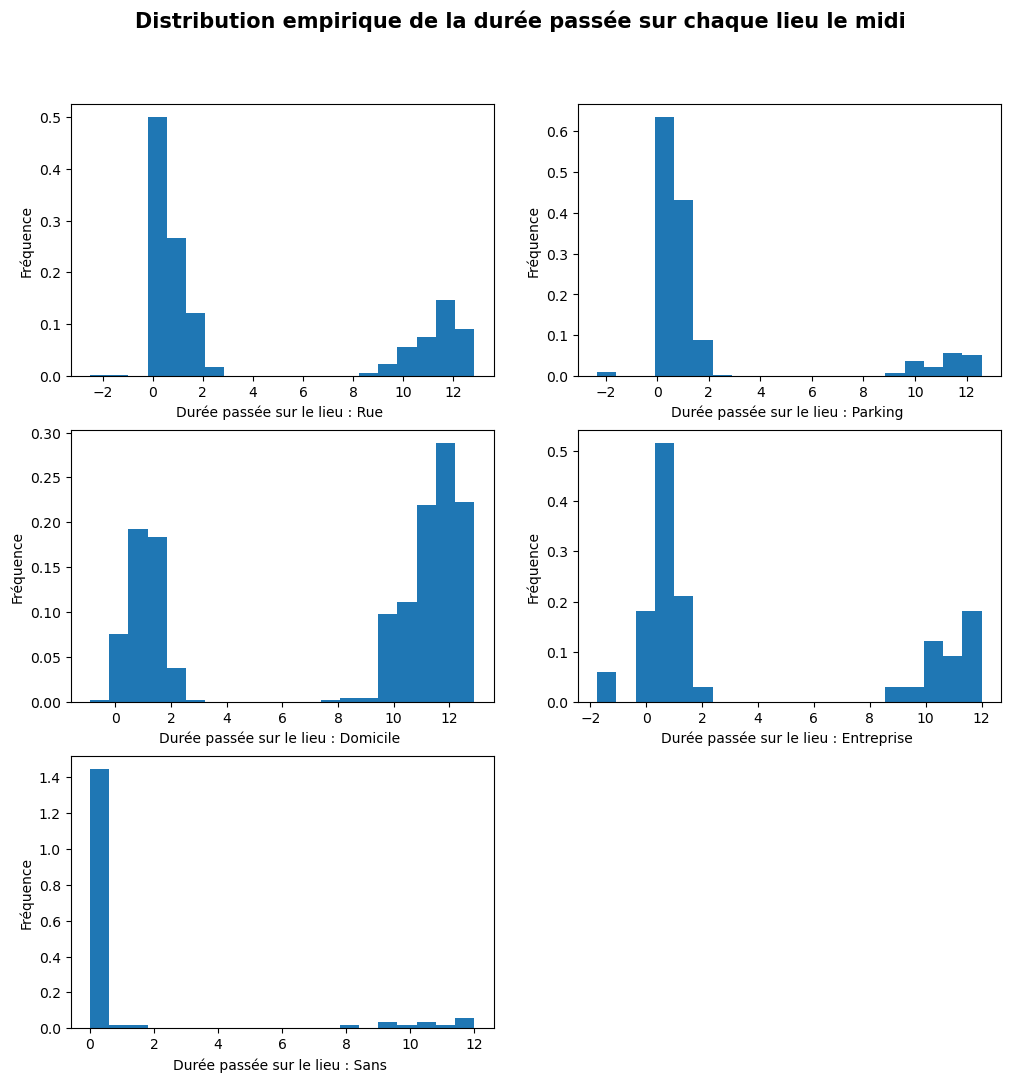

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    if j<1:
        j+=1
    else:
        i+=1
        j=0
ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le midi",va='center', fontweight="bold",fontsize=15,y=0.95)

Text(0.5, 0.95, "Distribution empirique de la durée passée sur chaque lieu l'après-midi")

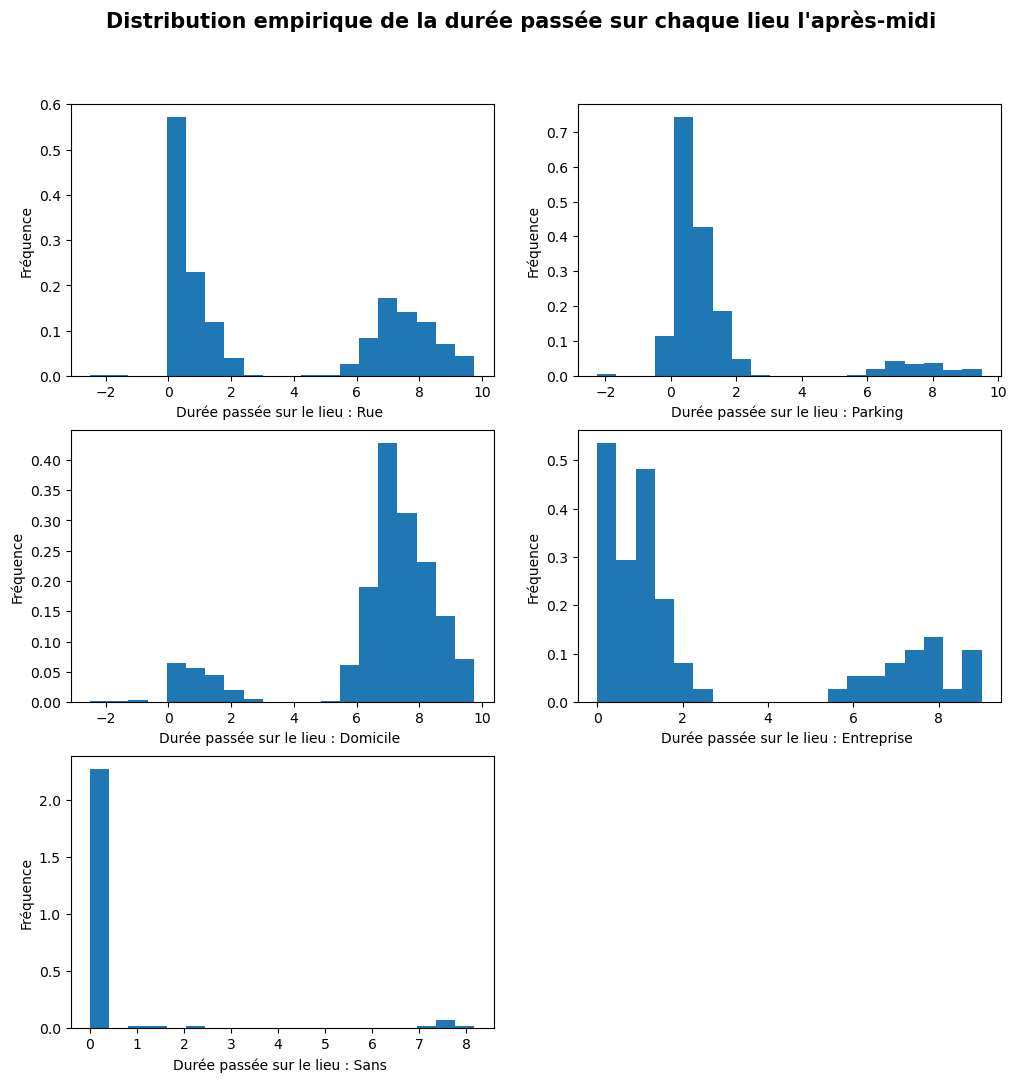

In [69]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    if j<1:
        j+=1
    else:
        i+=1
        j=0
ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu l'après-midi",va='center', fontweight="bold",fontsize=15,y=0.95)

Text(0.5, 0.95, 'Distribution empirique de la durée passée sur chaque lieu le soir')

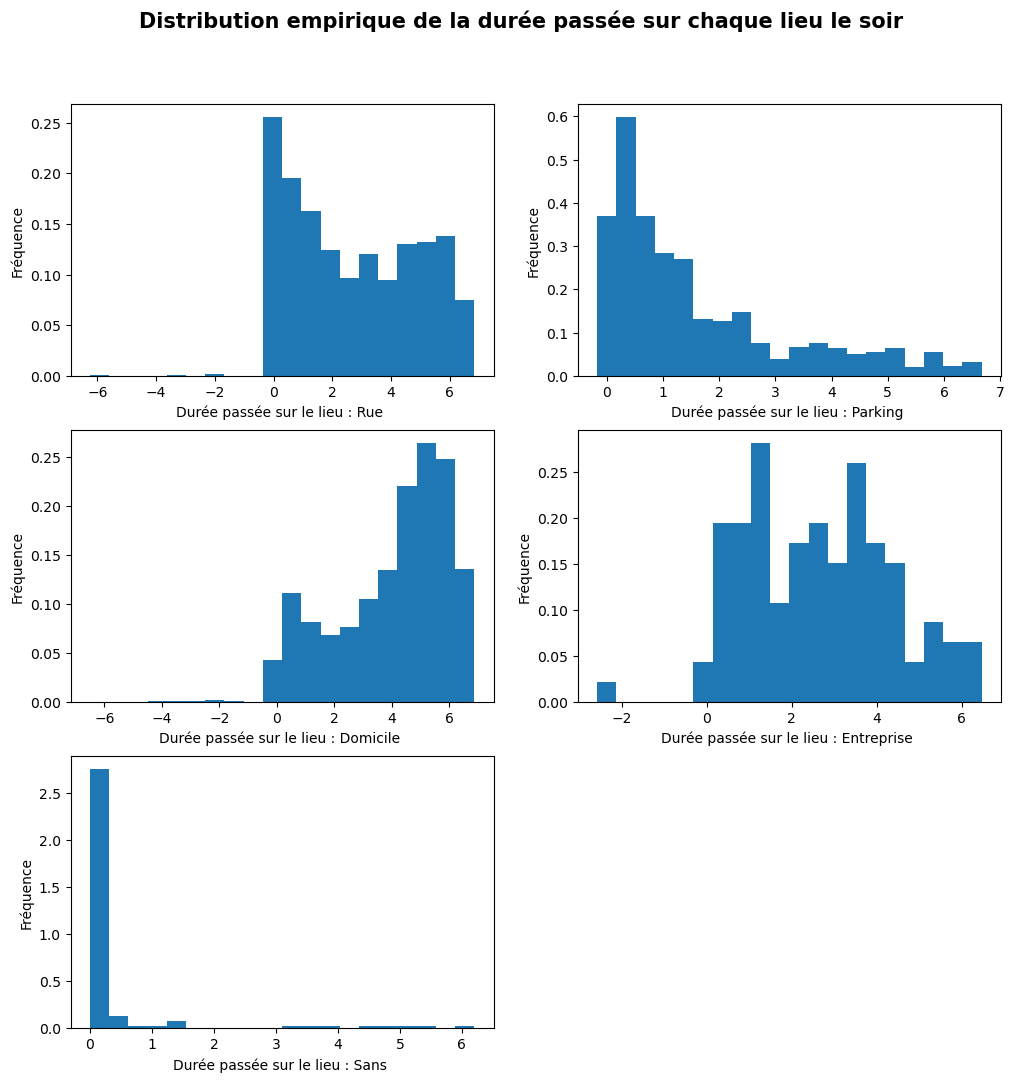

In [70]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
i=0
j=0
for lieu in list(set(emp_df["Lieu_Arrivee"])):
    emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
    if j<1:
        j+=1
    else:
        i+=1
        j=0
ax[2][1].set_axis_off()
fig.suptitle("Distribution empirique de la durée passée sur chaque lieu le soir",va='center', fontweight="bold",fontsize=15,y=0.95)